# Chapter 5: Deep Learning for Time Series Forecasting

In this notebook, we will use a multi-layer perceptron to develop time series forecasting models.
The dataset used for the examples of this notebook is on air pollution measured by concentration of
particulate matter (PM) of diameter less than or equal to 2.5 micrometers. There are other variables
such as air pressure, air temperature, dew point and so on.
Two time series models are developed - one on air pressure and the other on pm2.5.
The dataset has been downloaded from UCI Machine Learning Repository.

In [ ]:
#https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

## Chapter 5: Multi-Layer perceptrons (MLP) 
## Air Pressure

In [2]:
#https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [3]:
#Read the dataset into a pandas.DataFrame
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')

In [4]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (43824, 13)


In [5]:
#Let's see the first five rows of the DataFrame
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


To make sure that the rows are in the right order of date and time of observations,
a new column datetime is created from the date and time related columns of the DataFrame.
The new column consists of Python's datetime.datetime objects. The DataFrame is sorted in ascending order
over this column.

In [6]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

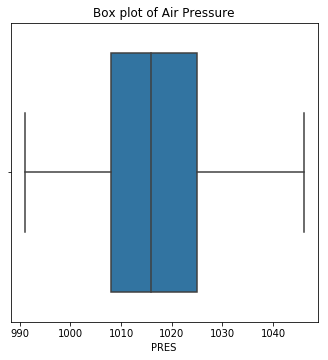

In [8]:
#Let us draw a box plot to visualize the central tendency 
#and dispersion of PRES
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot of Air Pressure')
plt.savefig('B07887_05_01.png', format='png', dpi=300)

/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


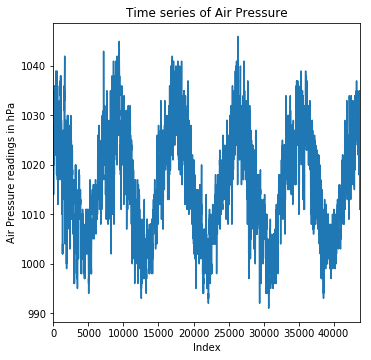

In [10]:
plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df['PRES'])
g.set_title('Time series of Air Pressure')
g.set_xlabel('Index')
g.set_ylabel('Air Pressure readings in hPa')
plt.savefig('B07887_05_02.png', format='png', dpi=300)

Gradient descent algorithms perform better (for example converge faster) if the variables are wihtin range [-1, 1]. Many sources relax the boundary to even [-3, 3]. The PRES variable is mixmax scaled to bound the tranformed variable within [0,1].

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))

Before training the model, the dataset is split in two parts - train set and validation set.
The neural network is trained on the train set. This means computation of the loss function, back propagation
and weights updated by a gradient descent algorithm is done on the train set. The validation set is
used to evaluate the model and to determine the number of epochs in model training. Increasing the number of 
epochs will further decrease the loss function on the train set but might not necessarily have the same effect
for the validation set due to overfitting on the train set.Hence, the number of epochs is controlled by keeping
a tap on the loss function computed for the validation set. We use Keras with Tensorflow backend to define and train
the model. All the steps involved in model training and validation is done by calling appropriate functions
of the Keras API.

In [10]:
"""
Let's start by splitting the dataset into train and validation. The dataset's time period is from
Jan 1st, 2010 to Dec 31st, 2014. The first four years - 2010 to 2013 is used as train and
2014 is kept for validation.
"""
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (35064, 15)
Shape of test: (8760, 15)


In [11]:
#First five rows of train
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


In [12]:
#First five rows of validation
df_val.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
35064,35065,2014,1,1,0,24.0,-20,7.0,1014.0,NW,143.48,0,0,2014-01-01 00:00:00,0.418182
35065,35066,2014,1,1,1,53.0,-20,7.0,1013.0,NW,147.50,0,0,2014-01-01 01:00:00,0.400000
35066,35067,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0,2014-01-01 02:00:00,0.400000
35067,35068,2014,1,1,3,70.0,-20,6.0,1013.0,NW,153.31,0,0,2014-01-01 03:00:00,0.400000
35068,35069,2014,1,1,4,79.0,-18,3.0,1012.0,cv,0.89,0,0,2014-01-01 04:00:00,0.381818


In [13]:
#Reset the indices of the validation set
df_val.reset_index(drop=True, inplace=True)

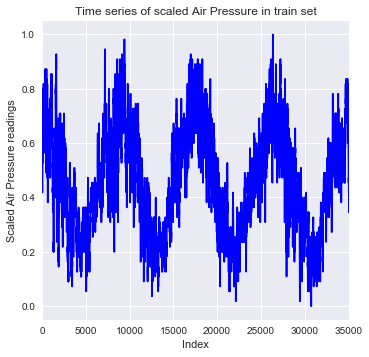

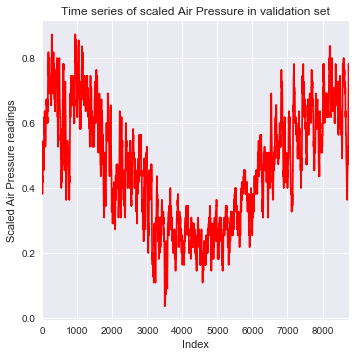

In [14]:
"""
The train and validation time series of standardized PRES are also plotted.
"""

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_train['scaled_PRES'], color='b')
g.set_title('Time series of scaled Air Pressure in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')
plt.savefig('B07887_05_03.png', format='png', dpi=300)

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_val['scaled_PRES'], color='r')
g.set_title('Time series of scaled Air Pressure in validation set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')
plt.savefig('plots/ch5/B07887_05_04.png', format='png', dpi=300)

Now we need to generate regressors (X) and target variable (y) for train and validation. 2-D array of regressors and 1-D array of target is created from the original 1-D array of column standardized_PRES in the DataFrames. For the time series forecasting model, Past seven days of observations are used to predict for the next day. This is equivalent to a AR(7) model. We define a function which takes the original time series and the number of timesteps in regressors as input to generate the arrays of X and y.

In [15]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [16]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (35057, 7) (35057,)


In [17]:
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (8753, 7) (8753,)


Now we define the MLP using the Keras Functional API. In this approach a layer can be declared as the input of the following layer at the time of defining the next layer. 

In [18]:
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [19]:
#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(7,), dtype='float32')

In [20]:
#Dense layers are defined with linear activation
dense1 = Dense(32, activation='linear')(input_layer)
dense2 = Dense(16, activation='linear')(dense1)
dense3 = Dense(16, activation='linear')(dense2)

Multiple hidden layers and large number of neurons in each hidden layer gives neural networks the ability to model complex non-linearity of the underlying relations between regressors and target. However, deep neural networks can also overfit train data and give poor results on validation or test set. Dropout has been effectively used to regularize deep neural networks. In this example, a Dropout layer is added before the output layer. Dropout randomly sets p fraction of input neurons to zero before passing to the next layer. Randomly dropping inputs essentially acts as a bootstrap aggregating or bagging type of model ensembling. Random forest uses bagging by building trees on random subsets of input features. We use p=0.2 to dropout 20% of randomly selected input features.

In [21]:
dropout_layer = Dropout(0.2)(dense3)

In [22]:
#Finally, the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

The input, dense and output layers will now be packed inside a Model, which is wrapper class for training and making
predictions. Mean square error (MSE) is used as the loss function.

The network's weights are optimized by the Adam algorithm. Adam stands for adaptive moment estimation
and has been a popular choice for training deep neural networks. Unlike, stochastic gradient descent, Adam uses
different learning rates for each weight and separately updates the same as the training progresses. The learning rate of a weight is updated based on exponentially weighted moving averages of the weight's gradients and the squared gradients.

In [23]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be used for a instance of back propagation. The validation dataset is also passed to evaluate the model after every epoch completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch, at which the loss function has been minimum.

In [24]:
save_weights_at = os.path.join('keras_models', 'PRSA_data_Air_Pressure_MLP_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 2s - loss: 0.0036 - val_loss: 2.5258e-04
Epoch 2/20
35057/35057 [==============================] - 3s - loss: 0.0010 - val_loss: 3.8358e-04
Epoch 3/20
35057/35057 [==============================] - 2s - loss: 8.5746e-04 - val_loss: 1.4754e-04
Epoch 4/20
35057/35057 [==============================] - 2s - loss: 8.1336e-04 - val_loss: 2.9480e-04
Epoch 5/20
35057/35057 [==============================] - 2s - loss: 7.9591e-04 - val_loss: 3.3620e-04
Epoch 6/20
35057/35057 [==============================] - 2s - loss: 7.7443e-04 - val_loss: 1.4424e-04
Epoch 7/20
35057/35057 [==============================] - 2s - loss: 7.8400e-04 - val_loss: 3.1264e-04
Epoch 8/20
35057/35057 [==============================] - 2s - loss: 7.8100e-04 - val_loss: 2.7084e-04
Epoch 9/20
35057/35057 [==============================] - 2s - loss: 7.5133e-04 - val_loss: 1.4237e-04
Epoch 10/20
35057/35057 [=======

Prediction are made for the air pressure from the best saved model. The model's predictions, which are on the scaled  air-pressure, are inverse transformed to get predictions on original air pressure. The goodness-of-fit or R squared is also calculated.

In [26]:
best_model = load_model(os.path.join('keras_models', 'PRSA_data_Air_Pressure_MLP_weights.13-0.0001.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

In [27]:
from sklearn.metrics import r2_score

In [28]:
r2 = r2_score(df_val['PRES'].loc[7:], pred_PRES)
print('R-squared for the validation set:', round(r2,4))

R-squared for the validation set: 0.9958


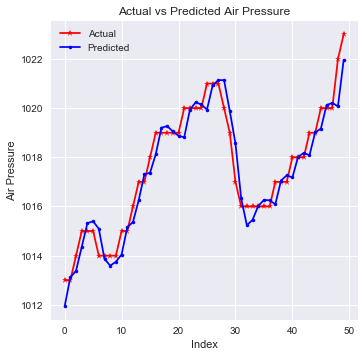

In [29]:
#Let's plot the first 50 actual and predicted values of air pressure.
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['PRES'].loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')
plt.savefig('B07887_05_05.png', format='png', dpi=300)

## Chapter 5: Recurrent Neural Networks (RNN)
## Long Short Term Memory (LSTM)
## Air Pressure

In this notebook, we will use Long Short Term Memory RNN to develop a time series forecasting model.
The dataset used for the examples of this notebook is on air pollution measured by concentration of
particulate matter (PM) of diameter less than or equal to 2.5 micrometers. There are other variables
such as air pressure, air temparature, dewpoint and so on.
Two time series models are developed - one on air pressure and the other on pm2.5.
The dataset has been downloaded from UCI Machine Learning Repository.

In [1]:
#https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
#set current working directory
os.chdir('D:/Practical Time Series')

In [3]:
#Read the dataset into a pandas.DataFrame
df = pd.read_csv('datasets/PRSA_data_2010.1.1-2014.12.31.csv')

In [4]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (43824, 13)


In [5]:
#Let's see the first five rows of the DataFrame
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


To make sure that the rows are in the right order of date and time of observations,
a new column datetime is created from the date and time related columns of the DataFrame.
The new column consists of Python's datetime.datetime objects. The DataFrame is sorted in ascending order
over this column.

In [6]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

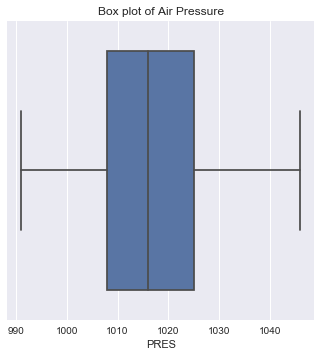

In [7]:
#Let us draw a box plot to visualize the central tendency and dispersion of PRES
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot of Air Pressure')

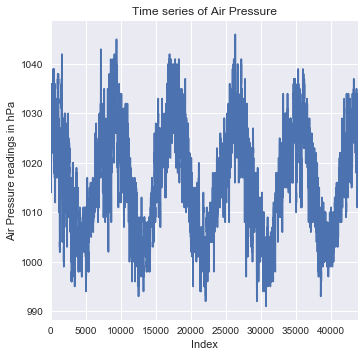

In [8]:
plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df['PRES'])
g.set_title('Time series of Air Pressure')
g.set_xlabel('Index')
g.set_ylabel('Air Pressure readings in hPa')

Gradient descent algorithms perform better (for example converge faster) if the variables are wihtin range [-1, 1]. Many sources relax the boundary to even [-3, 3]. The PRES variable is mixmax scaled to bound the tranformed variable within [0,1].

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))

Before training the model, the dataset is split in two parts - train set and validation set.
The neural network is trained on the train set. This means computation of the loss function, back propagation
and weights updated by a gradient descent algorithm is done on the train set. The validation set is
used to evaluate the model and to determine the number of epochs in model training. Increasing the number of 
epochs will further decrease the loss function on the train set but might not neccesarily have the same effect
for the validation set due to overfitting on the train set.Hence, the number of epochs is controlled by keeping
a tap on the loss function computed for the validation set. We use Keras with Tensorflow backend to define and train
the model. All the steps involved in model training and validation is done by calling appropriate functions
of the Keras API.

In [10]:
"""
Let's start by splitting the dataset into train and validation. The dataset's time period if from
Jan 1st, 2010 to Dec 31st, 2014. The first fours years - 2010 to 2013 is used as train and
2014 is kept for validation.
"""
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (35064, 15)
Shape of test: (8760, 15)


In [11]:
#First five rows of train
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


In [12]:
#First five rows of validation
df_val.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
35064,35065,2014,1,1,0,24.0,-20,7.0,1014.0,NW,143.48,0,0,2014-01-01 00:00:00,0.418182
35065,35066,2014,1,1,1,53.0,-20,7.0,1013.0,NW,147.50,0,0,2014-01-01 01:00:00,0.400000
35066,35067,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0,2014-01-01 02:00:00,0.400000
35067,35068,2014,1,1,3,70.0,-20,6.0,1013.0,NW,153.31,0,0,2014-01-01 03:00:00,0.400000
35068,35069,2014,1,1,4,79.0,-18,3.0,1012.0,cv,0.89,0,0,2014-01-01 04:00:00,0.381818


In [13]:
#Reset the indices of the validation set
df_val.reset_index(drop=True, inplace=True)

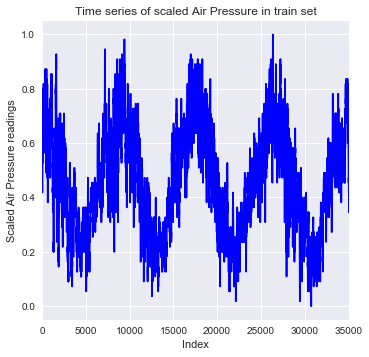

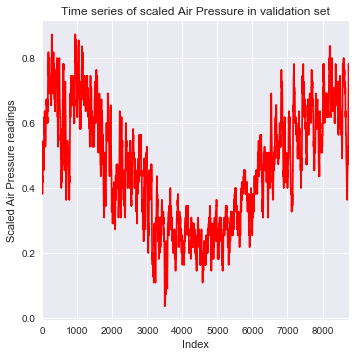

In [14]:
"""
The train and validation time series of standardized PRES is also plotted.
"""

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_train['scaled_PRES'], color='b')
g.set_title('Time series of scaled Air Pressure in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_val['scaled_PRES'], color='r')
g.set_title('Time series of scaled Air Pressure in validation set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')

Now we need to generate regressors (X) and target variable (y) for train and validation. 2-D array of regressor and 1-D array of target is created from the original 1-D array of columm log_PRES in the DataFrames. For the time series forecasting model, Past seven days of observations are used to predict for the next day. This is equivalent to a AR(7) model. We define a function which takes the original time series and the number of timesteps in regressors as input to generate the arrays of X and y.

In [15]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [16]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (35057, 7) (35057,)


In [17]:
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (8753, 7) (8753,)


The input to RNN layers must be of shape (number of samples, number of timesteps, number of features per timestep). In this case we are modeling only pm2.5 hence number of features per timestep is one. Number of timesteps is seven and number of samples is same as the number of samples in X_train and X_val, which are reshaped to 3D arrays.

In [18]:
X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)),\
                 X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of 3D arrays:', X_train.shape, X_val.shape)

Shape of 3D arrays: (35057, 7, 1) (8753, 7, 1)


Now we define the MLP using the Keras Functional API. In this approach a layer can be declared as the input of the following layer at the time of defining the next layer. 

In [19]:
from keras.layers import Dense, Input, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [20]:
#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(7,1), dtype='float32')

In [21]:
#LSTM layer is defined for seven timesteps
lstm_layer = LSTM(64, input_shape=(7,1), return_sequences=False)(input_layer)

In [22]:
dropout_layer = Dropout(0.2)(lstm_layer)

In [23]:
#Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

The input, dense and output layers will now be packed inside a Model, which is wrapper class for training and making
predictions. Mean square error (mse) is used as the loss function.

The network's weights are optimized by the Adam algorithm. Adam stands for adaptive moment estimation
and has been a popular choice for training deep neural networks. Unlike, stochastic gradient descent, adam uses
different learning rates for each weight and separately updates the same as the training progresses. The learning rate of a weight is updated based on exponentially weighted moving averages of the weight's gradients and the squared gradients.

In [24]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mae', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [25]:
"""
The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.
"""
save_weights_at = os.path.join('keras_models', 'PRSA_data_Air_Pressure_LSTM_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 16s - loss: 0.0317 - val_loss: 0.0140
Epoch 2/20
35057/35057 [==============================] - 16s - loss: 0.0191 - val_loss: 0.0108
Epoch 3/20
35057/35057 [==============================] - 16s - loss: 0.0155 - val_loss: 0.0095
Epoch 4/20
35057/35057 [==============================] - 16s - loss: 0.0144 - val_loss: 0.0099
Epoch 5/20
35057/35057 [==============================] - 17s - loss: 0.0140 - val_loss: 0.0104
Epoch 6/20
35057/35057 [==============================] - 16s - loss: 0.0137 - val_loss: 0.0094
Epoch 7/20
35057/35057 [==============================] - 18s - loss: 0.0136 - val_loss: 0.0087
Epoch 8/20
35057/35057 [==============================] - 15s - loss: 0.0134 - val_loss: 0.0087
Epoch 9/20
35057/35057 [==============================] - 15s - loss: 0.0135 - val_loss: 0.0097
Epoch 10/20
35057/35057 [==============================] - 15s - loss: 0.0135 - val_los

Prediction are made for the air pressure from the best saved model. The model's predictions, which are on the scaled  air-pressure, are inverse transformed to get predictions on original air pressure. The goodness-of-fit, R-squared is also calculated for the predictions on the original variable.

In [27]:
best_model = load_model(os.path.join('keras_models', 'PRSA_data_Air_Pressure_LSTM_weights.06-0.0087.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

In [28]:
from sklearn.metrics import r2_score
r2 = r2_score(df_val['PRES'].loc[7:], pred_PRES)
print('R-squared on validation set of the original air pressure:', r2)

R-squared on validation set of the original air pressure: 0.995760598851


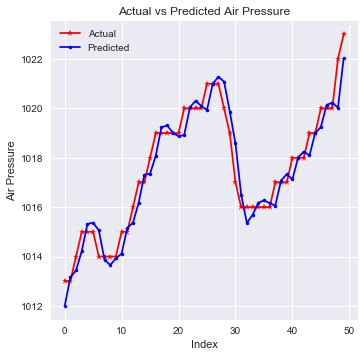

In [29]:
#Let's plot the first 50 actual and predicted values of air pressure.
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['PRES'].loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')
plt.savefig('plots/ch5/B07887_05_11.png', format='png', dpi=300)

## Gated Recurrent Unit (GRU)
## Air Pressure

In this notebook, we will use Gated Recurrent Unit RNN to develop a time series forecasting model.
The dataset used for the examples of this notebook is on air pollution measured by concentration of
particulate matter (PM) of diameter less than or equal to 2.5 micrometers. There are other variables
such as air pressure, air temparature, dewpoint and so on.
Two time series models are developed - one on air pressure and the other on pm2.5.
The dataset has been downloaded from UCI Machine Learning Repository.

In [1]:
#https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
#set current working directory
os.chdir('D:/Practical Time Series')

In [3]:
#Read the dataset into a pandas.DataFrame
df = pd.read_csv('datasets/PRSA_data_2010.1.1-2014.12.31.csv')

In [4]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (43824, 13)


In [5]:
#Let's see the first five rows of the DataFrame
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


To make sure that the rows are in the right order of date and time of observations,
a new column datetime is created from the date and time related columns of the DataFrame.
The new column consists of Python's datetime.datetime objects. The DataFrame is sorted in ascending order
over this column.

In [6]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

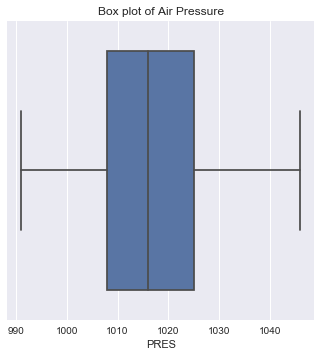

In [7]:
#Let us draw a box plot to visualize the central tendency and dispersion of PRES
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot of Air Pressure')

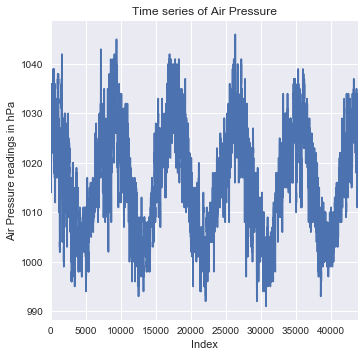

In [8]:
plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df['PRES'])
g.set_title('Time series of Air Pressure')
g.set_xlabel('Index')
g.set_ylabel('Air Pressure readings in hPa')

Gradient descent algorithms perform better (for example converge faster) if the variables are wihtin range [-1, 1]. The PRES variable is minmax scaled as shown in the following cell in order to bound the scaled features within [0, 1].

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))

Before training the model, the dataset is split in two parts - train set and validation set.
The neural network is trained on the train set. This means computation of the loss function, back propagation
and weights updated by a gradient descent algorithm is done on the train set. The validation set is
used to evaluate the model and to determine the number of epochs in model training. Increasing the number of 
epochs will further decrease the loss function on the train set but might not neccesarily have the same effect
for the validation set due to overfitting on the train set.Hence, the number of epochs is controlled by keeping
a tap on the loss function computed for the validation set. We use Keras with Tensorflow backend to define and train
the model. All the steps involved in model training and validation is done by calling appropriate functions
of the Keras API.

In [10]:
"""
Let's start by splitting the dataset into train and validation. The dataset's time period if from
Jan 1st, 2010 to Dec 31st, 2014. The first fours years - 2010 to 2013 is used as train and
2014 is kept for validation.
"""
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (35064, 15)
Shape of test: (8760, 15)


In [11]:
#First five rows of train
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


In [12]:
#First five rows of validation
df_val.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
35064,35065,2014,1,1,0,24.0,-20,7.0,1014.0,NW,143.48,0,0,2014-01-01 00:00:00,0.418182
35065,35066,2014,1,1,1,53.0,-20,7.0,1013.0,NW,147.50,0,0,2014-01-01 01:00:00,0.400000
35066,35067,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0,2014-01-01 02:00:00,0.400000
35067,35068,2014,1,1,3,70.0,-20,6.0,1013.0,NW,153.31,0,0,2014-01-01 03:00:00,0.400000
35068,35069,2014,1,1,4,79.0,-18,3.0,1012.0,cv,0.89,0,0,2014-01-01 04:00:00,0.381818


In [13]:
#Reset the indices of the validation set
df_val.reset_index(drop=True, inplace=True)

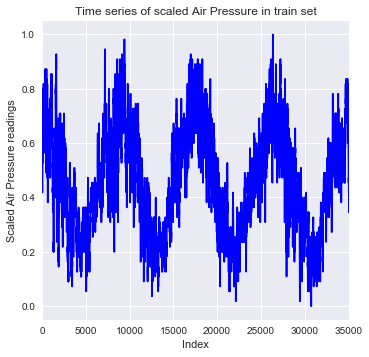

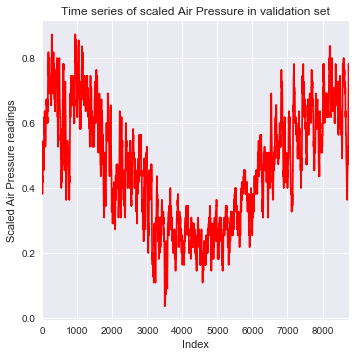

In [14]:
"""
The train and validation time series of standardized PRES is also plotted.
"""

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_train['scaled_PRES'], color='b')
g.set_title('Time series of scaled Air Pressure in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_val['scaled_PRES'], color='r')
g.set_title('Time series of scaled Air Pressure in validation set')
g.set_xlabel('Index')
g.set_ylabel('Scaled Air Pressure readings')

Now we need to generate regressors (X) and target variable (y) for train and validation. 2-D array of regressor and 1-D array of target is created from the original 1-D array of columm scaled_PRES in the DataFrames. For the time series forecasting model, Past seven days of observations are used to predict for the next day. This is equivalent to a AR(7) model. We define a function which takes the original time series and the number of timesteps in regressors as input to generate the arrays of X and y.

In [15]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [16]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (35057, 7) (35057,)


In [17]:
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (8753, 7) (8753,)


The input to RNN layers must be of shape (number of samples, number of timesteps, number of features per timestep). In this case we are modeling only pm2.5 hence number of features per timestep is one. Number of timesteps is seven and number of samples is same as the number of samples in X_train and X_val, which are reshaped to 3D arrays.

In [18]:
X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of 3D arrays:', X_train.shape, X_val.shape)

Shape of 3D arrays: (35057, 7, 1) (8753, 7, 1)


Now we define the MLP using the Keras Functional API. In this approach a layer can be declared as the input of the following layer at the time of defining the next layer. 

In [19]:
from keras.layers import Dense, Input, Dropout
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [20]:
#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(7,1), dtype='float32')

In [21]:
#LSTM layer is defined for seven timesteps
gru_layer = GRU(64, input_shape=(7,1), return_sequences=False)(input_layer)

In [22]:
dropout_layer = Dropout(0.2)(gru_layer)

In [23]:
#Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

The input, dense and output layers will now be packed inside a Model, which is wrapper class for training and making
predictions. Mean square error (mse) is used as the loss function.

The network's weights are optimized by the Adam algorithm. Adam stands for adaptive moment estimation
and has been a popular choice for training deep neural networks. Unlike, stochastic gradient descent, adam uses
different learning rates for each weight and separately updates the same as the training progresses. The learning rate of a weight is updated based on exponentially weighted moving averages of the weight's gradients and the squared gradients.

In [24]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mse', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                12672     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
_________________________________________________________________


In [25]:
"""
The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.
"""
save_weights_at = os.path.join('keras_models', 'PRSA_data_Air_Pressure_GRU_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 16s - loss: 0.0020 - val_loss: 3.3810e-04
Epoch 2/20
35057/35057 [==============================] - 23s - loss: 6.2747e-04 - val_loss: 1.4782e-04
Epoch 3/20
35057/35057 [==============================] - 19s - loss: 3.9528e-04 - val_loss: 1.5410e-04
Epoch 4/20
35057/35057 [==============================] - 12s - loss: 3.2953e-04 - val_loss: 1.4294e-04
Epoch 5/20
35057/35057 [==============================] - 13s - loss: 3.1658e-04 - val_loss: 1.4473e-04
Epoch 6/20
35057/35057 [==============================] - 11s - loss: 3.1082e-04 - val_loss: 1.4149e-04
Epoch 7/20
35057/35057 [==============================] - 12s - loss: 3.0778e-04 - val_loss: 2.3025e-04
Epoch 8/20
35057/35057 [==============================] - 12s - loss: 3.1214e-04 - val_loss: 1.6912e-04
Epoch 9/20
35057/35057 [==============================] - 12s - loss: 3.0986e-04 - val_loss: 1.4575e-04
Epoch 10/20
35057/3

Prediction are made for the air pressure from the best saved model. The model's predictions, which are on the minmax scaled  air-pressure, are inverse transformed to get predictions on original air pressure. The goodness-of-fit, R-squared is also calculated for the predictions on the original variable.

In [27]:
best_model = load_model(os.path.join('keras_models', 'PRSA_data_Air_Pressure_GRU_weights.17-0.0001.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

In [28]:
from sklearn.metrics import r2_score
r2 = r2_score(df_val['PRES'].loc[7:], pred_PRES)
print('R-squared on validation set of the original air pressure:', r2)

R-squared on validation set of the original air pressure: 0.995799194476


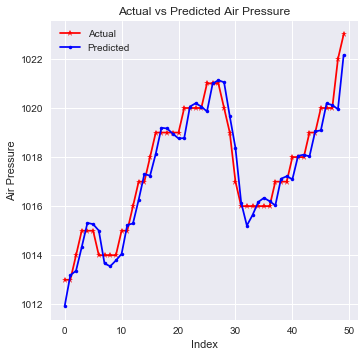

In [29]:
#Let's plot the first 50 actual and predicted values of air pressure.
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['PRES'].loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('Air Pressure')
plt.xlabel('Index')

## Chapter 5: Convolutional neural networks (CNNs) (1D Convolution)
## Air Pressure

In this notebook, we will use a multi-layer perceptron to develop time series forecasting models.
The dataset used for the examples of this notebook is on air pollution measured by concentration of
particulate matter (PM) of diameter less than or equal to 2.5 micrometers. There are other variables
such as air pressure, air temparature, dewpoint and so on.
Two time series models are developed - one on air pressure and the other on pm2.5.
The dataset has been downloaded from UCI Machine Learning Repository.

In [ ]:
#https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [2]:
#set current working directory
os.chdir('D:/Practical Time Series')

In [3]:
#Read the dataset into a pandas.DataFrame
df = pd.read_csv('datasets/PRSA_data_2010.1.1-2014.12.31.csv')

In [4]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (43824, 13)


In [5]:
#Let's see the first five rows of the DataFrame
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


To make sure that the rows are in the right order of date and time of observations,
a new column datetime is created from the date and time related columns of the DataFrame.
The new column consists of Python's datetime.datetime objects. The DataFrame is sorted in ascending order
over this column.

In [6]:
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

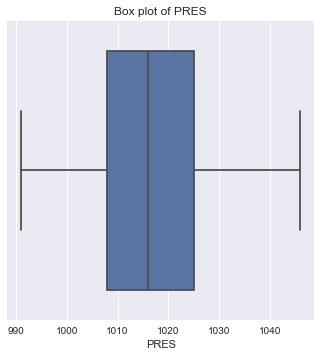

In [7]:
#Let us draw a box plot to visualize the central tendency and dispersion of PRES
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['PRES'])
g.set_title('Box plot of PRES')

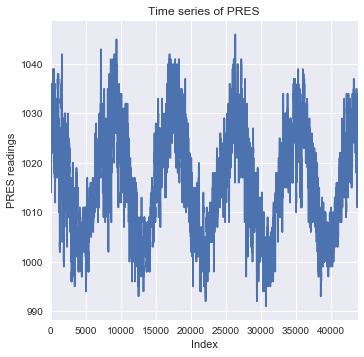

In [8]:
plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df['PRES'])
g.set_title('Time series of PRES')
g.set_xlabel('Index')
g.set_ylabel('PRES readings')

Gradient descent algorithms perform better (for example converge faster) if the variables are wihtin range [-1, 1]. Many sources relax the boundary to even [-3, 3]. The PRES variable is mixmax scaled to bound the tranformed variable within [0,1].

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_PRES'] = scaler.fit_transform(np.array(df['PRES']).reshape(-1, 1))

Before training the model, the dataset is split in two parts - train set and validation set.
The neural network is trained on the train set. This means computation of the loss function, back propagation
and weights updated by a gradient descent algorithm is done on the train set. The validation set is
used to evaluate the model and to determine the number of epochs in model training. Increasing the number of 
epochs will further decrease the loss function on the train set but might not neccesarily have the same effect
for the validation set due to overfitting on the train set.Hence, the number of epochs is controlled by keeping
a tap on the loss function computed for the validation set. We use Keras with Tensorflow backend to define and train
the model. All the steps involved in model training and validation is done by calling appropriate functions
of the Keras API.

In [10]:
"""
Let's start by splitting the dataset into train and validation. The dataset's time period if from
Jan 1st, 2010 to Dec 31st, 2014. The first fours years - 2010 to 2013 is used as train and
2014 is kept for validation.
"""
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (35064, 15)
Shape of test: (8760, 15)


In [11]:
#First five rows of train
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.545455
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.527273
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.509091
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.509091
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.490909


In [12]:
#First five rows of validation
df_val.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_PRES
35064,35065,2014,1,1,0,24.0,-20,7.0,1014.0,NW,143.48,0,0,2014-01-01 00:00:00,0.418182
35065,35066,2014,1,1,1,53.0,-20,7.0,1013.0,NW,147.50,0,0,2014-01-01 01:00:00,0.400000
35066,35067,2014,1,1,2,65.0,-20,6.0,1013.0,NW,151.52,0,0,2014-01-01 02:00:00,0.400000
35067,35068,2014,1,1,3,70.0,-20,6.0,1013.0,NW,153.31,0,0,2014-01-01 03:00:00,0.400000
35068,35069,2014,1,1,4,79.0,-18,3.0,1012.0,cv,0.89,0,0,2014-01-01 04:00:00,0.381818


In [13]:
#Reset the indices of the validation set
df_val.reset_index(drop=True, inplace=True)

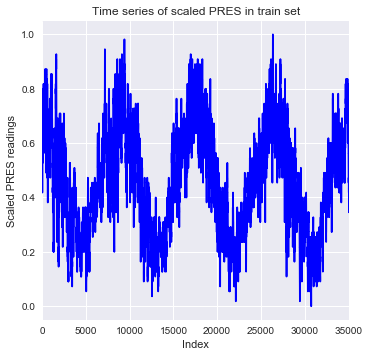

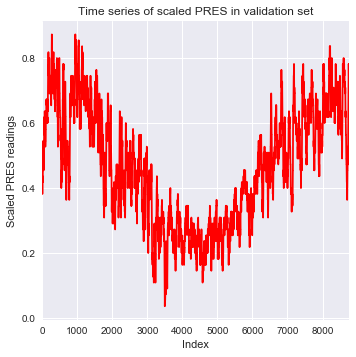

In [14]:
"""
The train and validation time series of scaled PRES is also plotted.
"""

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_train['scaled_PRES'], color='b')
g.set_title('Time series of scaled PRES in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled PRES readings')

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_val['scaled_PRES'], color='r')
g.set_title('Time series of scaled PRES in validation set')
g.set_xlabel('Index')
g.set_ylabel('Scaled PRES readings')

Now we need to generate regressors (X) and target variable (y) for train and validation. 2-D array of regressor and 1-D array of target is created from the original 1-D array of columm standardized_PRES in the DataFrames. For the time series forecasting model, Past seven days of observations are used to predict for the next day. This is equivalent to a AR(7) model. We define a function which takes the original time series and the number of timesteps in regressors as input to generate the arrays of X and y.

In [15]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [16]:
X_train, y_train = makeXy(df_train['scaled_PRES'], 7)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (35057, 7) (35057,)


In [17]:
X_val, y_val = makeXy(df_val['scaled_PRES'], 7)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (8753, 7) (8753,)


The input to convolution layers must be of shape (number of samples, number of timesteps, number of features per timestep). In this case we are modeling only PRES hence number of features per timestep is one. Number of timesteps is seven and number of samples is same as the number of samples in X_train and X_val, which are reshaped to 3D arrays.

In [18]:
#X_train and X_val are reshaped to 3D arrays
X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)),\
                 X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of arrays after reshaping:', X_train.shape, X_val.shape)

Shape of arrays after reshaping: (35057, 7, 1) (8753, 7, 1)


Now we define the MLP using the Keras Functional API. In this approach a layer can be declared as the input of the following layer at the time of defining the next layer. 

In [19]:
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import ZeroPadding1D
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import AveragePooling1D
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [20]:
#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(7,1), dtype='float32')

ZeroPadding1D layer is added next to add zeros at the beginning and end of each series. Zeropadding ensure that the downstream convolution layer does not reduce the dimension of the output sequences. Pooling layer, added after the convolution layer is used to downsampling the input.

In [21]:
#Add zero padding
zeropadding_layer = ZeroPadding1D(padding=1)(input_layer)

The first argument of Conv1D is the number of filters, which determine the number of features in the output. Second argument indicates length of the 1D convolution window. The third argument is strides and represent the number of places to shift the convolution window. Lastly, setting use_bias as True, add a bias value during computation of an output feature. Here, the 1D convolution can be thought of as generating local AR models over rolling window of three time units.

In [22]:
#Add 1D convolution layer
conv1D_layer = Conv1D(64, 3, strides=1, use_bias=True)(zeropadding_layer)

AveragePooling1D is added next to downsample the input by taking average over pool size of three with stride of one timesteps. The average pooling in this case can be thought of as taking moving averages over a rolling window of three time units. We have used average pooling instead of max pooling to generate the moving averages.

In [23]:
#Add AveragePooling1D layer
avgpooling_layer = AveragePooling1D(pool_size=3, strides=1)(conv1D_layer)

The preceeding pooling layer returns 3D output. Hence before passing to the output layer, a Flatten layer is added. The Flatten layer reshapes the input to (number of samples, number of timesteps*number of features per timestep), which is then fed to the output layer

In [24]:
#Add Flatten layer
flatten_layer = Flatten()(avgpooling_layer)

In [25]:
dropout_layer = Dropout(0.2)(flatten_layer)

In [26]:
#Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

The input, dense and output layers will now be packed inside a Model, which is wrapper class for training and making
predictions. Mean squared error (MSE) is used as the loss function.

The network's weights are optimized by the Adam algorithm. Adam stands for adaptive moment estimation
and has been a popular choice for training deep neural networks. Unlike, stochastic gradient descent, adam uses
different learning rates for each weight and separately updates the same as the training progresses. The learning rate of a weight is updated based on exponentially weighted moving averages of the weight's gradients and the squared gradients.

In [27]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')#SGD(lr=0.001, decay=1e-5))
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 9, 1)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             256       
_________________________________________________________________
average_pooling1d_1 (Average (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 321       
Total para

The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.

In [28]:
save_weights_at = os.path.join('keras_models', 'PRSA_data_Air_Pressure_1DConv_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Train on 35057 samples, validate on 8753 samples
Epoch 1/20
35057/35057 [==============================] - 3s - loss: 0.0277 - val_loss: 0.0182
Epoch 2/20
35057/35057 [==============================] - 3s - loss: 0.0176 - val_loss: 0.0116
Epoch 3/20
35057/35057 [==============================] - 5s - loss: 0.0156 - val_loss: 0.0368
Epoch 4/20
35057/35057 [==============================] - 3s - loss: 0.0147 - val_loss: 0.0114
Epoch 5/20
35057/35057 [==============================] - 4s - loss: 0.0141 - val_loss: 0.0109
Epoch 6/20
35057/35057 [==============================] - 3s - loss: 0.0139 - val_loss: 0.0159
Epoch 7/20
35057/35057 [==============================] - 3s - loss: 0.0136 - val_loss: 0.0169
Epoch 8/20
35057/35057 [==============================] - 3s - loss: 0.0137 - val_loss: 0.0159
Epoch 9/20
35057/35057 [==============================] - 3s - loss: 0.0136 - val_loss: 0.0101
Epoch 10/20
35057/35057 [==============================] - 3s - loss: 0.0135 - val_loss: 0.0110


Prediction are made for the PRES from the best saved model. The model's predictions, which are on the standardized  PRES, are inverse transformed to get predictions of original PRES.

In [30]:
best_model = load_model(os.path.join('keras_models', 'PRSA_data_Air_Pressure_1DConv_weights.16-0.0097.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = np.squeeze(scaler.inverse_transform(preds))

In [31]:
from sklearn.metrics import r2_score

In [32]:
r2 = r2_score(df_val['PRES'].loc[7:], pred_PRES)
print('R-squared for the validation set:', round(r2, 4))

R-squared for the validation set: 0.995


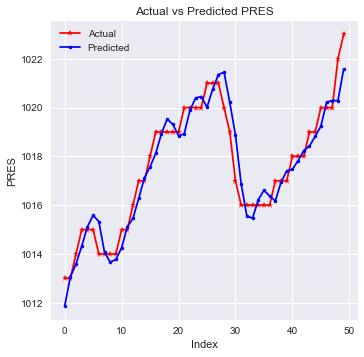

In [34]:
#Let's plot the first 50 actual and predicted values of PRES.
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), df_val['PRES'].loc[7:56], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_PRES[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted PRES')
plt.ylabel('PRES')
plt.xlabel('Index')